In [1]:
# import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from eemeter.development.data import HourlyData

# import time

# from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
# from eemeter.common.metrics import BaselineTestingMetrics as Metrics

# import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
#load subsamples from the main MCE dataset
dataset = 'mce'
subsample = 1
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_meta_1.pkl
Done in 0.006 s
Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_hourly_meter_1.pkl
Done in 5.078 s


In [3]:
lowest_mean = 0
for id_index, id in enumerate(ids):
    meter_id = id
    meter = subsample_df.loc[meter_id].copy()
    meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

    mn = meter_baseline['observed'].mean()

    if mn > lowest_mean:
        lowest_mean = mn
        lowest_meter = meter_id
        min_idx = id_index
print(f"Lowest mean: {lowest_mean}")
print(f"Lowest meter: {lowest_meter}")
print("Min ID: ", min_idx)
meter = subsample_df.loc[lowest_meter].copy()
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()

Lowest mean: 194.48479217715348
Lowest meter: None-9097391784_1-9097391784_1
Min ID:  970


In [4]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    SUPPLEMENTAL_DATA=None,
    # SUPPLEMENTAL_DATA=['solar_supp'],
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

In [135]:
# get one meter
meter_id = ids[104]
meter = subsample_df.loc[meter_id].copy()
# PV_interventation = "2019-11-09"
PV_interventation = "2021-01-21"

#change PV_interventation to datetime
PV_interventation = pd.to_datetime(PV_interventation)
meter['solar_supp'] = 0
meter.loc[meter['date'] >= PV_interventation.date(), 'solar_supp'] = 1

# select baseline period
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

meta_meter = meta.loc[meter_id]

# get unique pair of station_latitude and station_longitude
unique_pairs = meta_meter[['station_latitude', 'station_longitude']].drop_duplicates()

# print unique pairs
METADATA = {
    'station_latitude': unique_pairs['station_latitude'].values[0],
    'station_longitude': unique_pairs['station_longitude'].values[0],
}

#TODO: keep it simple and let the input force the output
OUTPUT_FEATURES=['temperature', 'observed', 'model', 'solar_supp']
if 'ghi' in settings.TRAIN_FEATURES:
    CONSIDER_SOLAR = True
    OUTPUT_FEATURES.append('ghi')
    OUTPUT_FEATURES.append('clearsky_ghi')
else:
    CONSIDER_SOLAR = False
kwargs = {
    'solar': CONSIDER_SOLAR,
    'metadata': METADATA,
    'outputs': OUTPUT_FEATURES,
}
data_baseline = HourlyData(meter_baseline, **kwargs)

In [136]:
model = em.HourlyModel(settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


## Interpolation analysis

In [137]:
#remove random time slots for temperature and make them nan
np.random.seed = 27
random_slots = np.random.choice(meter_baseline['datetime'], 0, replace=False)
meter_baseline_nans = meter_baseline.copy()
meter_baseline_nans.loc[meter_baseline_nans['datetime'].isin(random_slots), 'temperature'] = np.nan
print(meter_baseline_nans['temperature'].isna().sum())
print(meter_baseline_nans['observed'].isna().sum())

0
66


2020-01-03


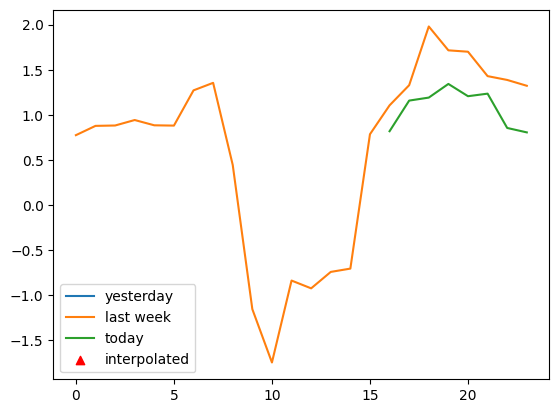

2020-02-10


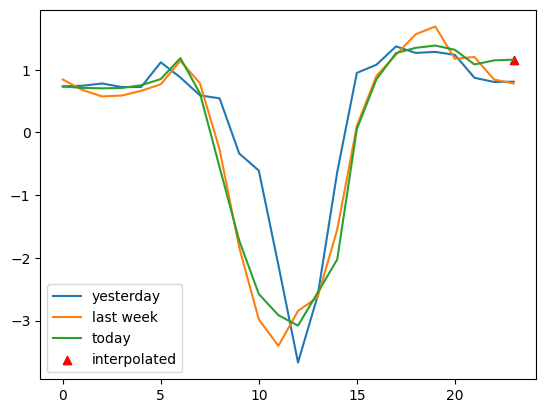

[datetime.date(2020, 1, 1), datetime.date(2020, 1, 2)]


In [139]:
from scipy.interpolate import RBFInterpolator, griddata, LinearNDInterpolator, NearestNDInterpolator, CloughTocher2DInterpolator

"""griddata: need an actual limit for the input such as temp (like a grid) which we don't want to have
   LinearNDInterpolator" if the data is out of bound based on the train data, it gives us nan :( which is crazy that it doesn't even extrapolate
   NearestNDInterpolator: values are descrete and way off sometimes (we have the mean value of couple of classes)
   CloughTocher2DInterpolator: same as LinearNDInterpolator


   Some crazy interpolation is already happening in the MCE temperature (last week and the day before temperatures were exactly the same (reason we we getting singularity in interpolation))
"""
def remove_duplicate_datetime(df):
    if "observed" in df.columns:
        # find duplicate datetime values and remove if nan
        duplicate_dt_mask = df.duplicated(subset="datetime", keep=False)
        observed_nan_mask = df['observed'].isna()
        df = df[~(duplicate_dt_mask & observed_nan_mask)]

        # if duplicated and observed is not nan, keep the largest abs(value)
        df["abs_observed"] = df["observed"].abs()
        df = df.sort_values(by=["datetime", "abs_observed"], ascending=[True, False])
        df = df.drop_duplicates(subset="datetime", keep="first")
        df = df.drop(columns=["abs_observed"])

    else:
        # TODO what if there is no observed column? Could have dup datetime with different temperatures
        df = df.drop_duplicates(subset="datetime", keep="first")

    return df

grouped_meter_baseline = meter_baseline_nans.copy()
grouped_meter_baseline['interpolated'] = False
grouped_meter_baseline = grouped_meter_baseline.groupby('date')


none_regular_dates = []
daily_thr_nans = 0
seeds = [0, 1]
for date, group in grouped_meter_baseline:
    group = remove_duplicate_datetime(group)
    if (
        group['temperature'].isna().sum() > daily_thr_nans
        ) or (
            group['observed'].isna().sum() > daily_thr_nans
        ):

        #remove any duplicate

        interpolation_columns = ['temperature', 'observed']

        #get previous week date and yesterday
        yesterday = date - pd.DateOffset(day=1)
        yesterday_df = meter_baseline.loc[meter_baseline['date']==yesterday.date()]
        yesterday_df = remove_duplicate_datetime(yesterday_df)

        last_week = date - pd.DateOffset(weeks=1)
        last_week_df = meter_baseline.loc[meter_baseline['date']==last_week.date()]
        last_week_df = remove_duplicate_datetime(last_week_df)

        if ((yesterday_df.empty==True) and (last_week_df.empty==True)):
            #make a linear interpolation from what we have
            group[interpolation_columns] = group[interpolation_columns].interpolate()

        else:
            intepolation_helper_days = []
            if yesterday_df.empty==False:
                intepolation_helper_days.append(yesterday_df)
            
            if last_week_df.empty==False:
                intepolation_helper_days.append(last_week_df)

            helper_vectors_nans = []
            helper_vectors_normal = []

            for inter_col in interpolation_columns:
                if group[inter_col].isna().sum()>0:
                    # print(inter_col)
                    for i, interp_df in enumerate(intepolation_helper_days):
                
                        # get index of those without temperature
                        nan_hours = group.loc[group[inter_col].isna()]['hour_of_day'].values
                        interp_df_nans = interp_df.loc[interp_df['hour_of_day'].isin(nan_hours)][inter_col].values

                        #get any other hours that is not in nan_hours
                        normal_hours = group.loc[~group[inter_col].isna()]['hour_of_day'].values
                        interp_df_normal = interp_df.loc[interp_df['hour_of_day'].isin(normal_hours)][inter_col].values

                        #singularity prevention
                        np.random.seed = seeds[i]
                        noise = np.random.normal(0, 1, len(interp_df_normal))
                        interp_df_normal += noise

                        helper_vectors_normal.append(interp_df_normal)
                        helper_vectors_nans.append(interp_df_nans)
                        
                    if len(helper_vectors_normal) == 1:
                        temp_vector_normal = helper_vectors_normal[0].reshape(-1,1)
                        temp_vector_nans = helper_vectors_nans[0].reshape(-1,1)
                    else:
                        temp_vector_normal = list(zip(helper_vectors_normal[0], helper_vectors_normal[1]))
                        temp_vector_nans = list(zip(helper_vectors_nans[0], helper_vectors_nans[1]))

                        
                    # target_vector = group.loc[~group[inter_col].isna()][inter_col].values
                    target_vector = group.loc[group['hour_of_day'].isin(normal_hours)][inter_col].values
                    if len(target_vector)==0:
                        none_regular_dates.append(date)
                        pass
                    else:
                        interp = RBFInterpolator(temp_vector_normal, target_vector)
                        preds = interp(temp_vector_nans)
                        group.loc[group['hour_of_day'].isin(nan_hours), inter_col] = preds

                        x = group['hour_of_day'].values
                        for j, interp_df in enumerate(intepolation_helper_days):
                            lbl = 'yesterday'
                            if j==1:
                                lbl = 'last week'
                            plt.plot(x,interp_df[inter_col], label = lbl)
                        
                        plt.plot(x,group[inter_col], label = 'today')
                        #plot temp values for interpolated hours as red
                        xp = group.loc[group['hour_of_day'].isin(nan_hours)]['hour_of_day'].values
                        plt.scatter(xp, group.loc[group['hour_of_day'].isin(nan_hours), inter_col], marker='^', color='red',label='interpolated')
                        print(date)
                        plt.legend()
                        plt.show()

print(none_regular_dates)

In [110]:
len(target_vector)

23

In [113]:
temp_vector_normal

array([53.45361989, 53.18324868, 52.93913502, 51.32132745, 52.67130183,
       52.08110111, 52.46182165, 50.93480478, 54.15205945, 53.83880919,
       53.664922  , 55.22899708, 54.57480673, 55.03580187, 54.09293376,
       55.52957993, 55.64956607, 54.66328388, 55.61607748, 51.96723172,
       53.92876922, 53.40858757, 53.71023708])

In [98]:
temp_vector_normal

[]

In [87]:
nan_hours

array([1], dtype=int32)

In [42]:
len(target_vector)

25

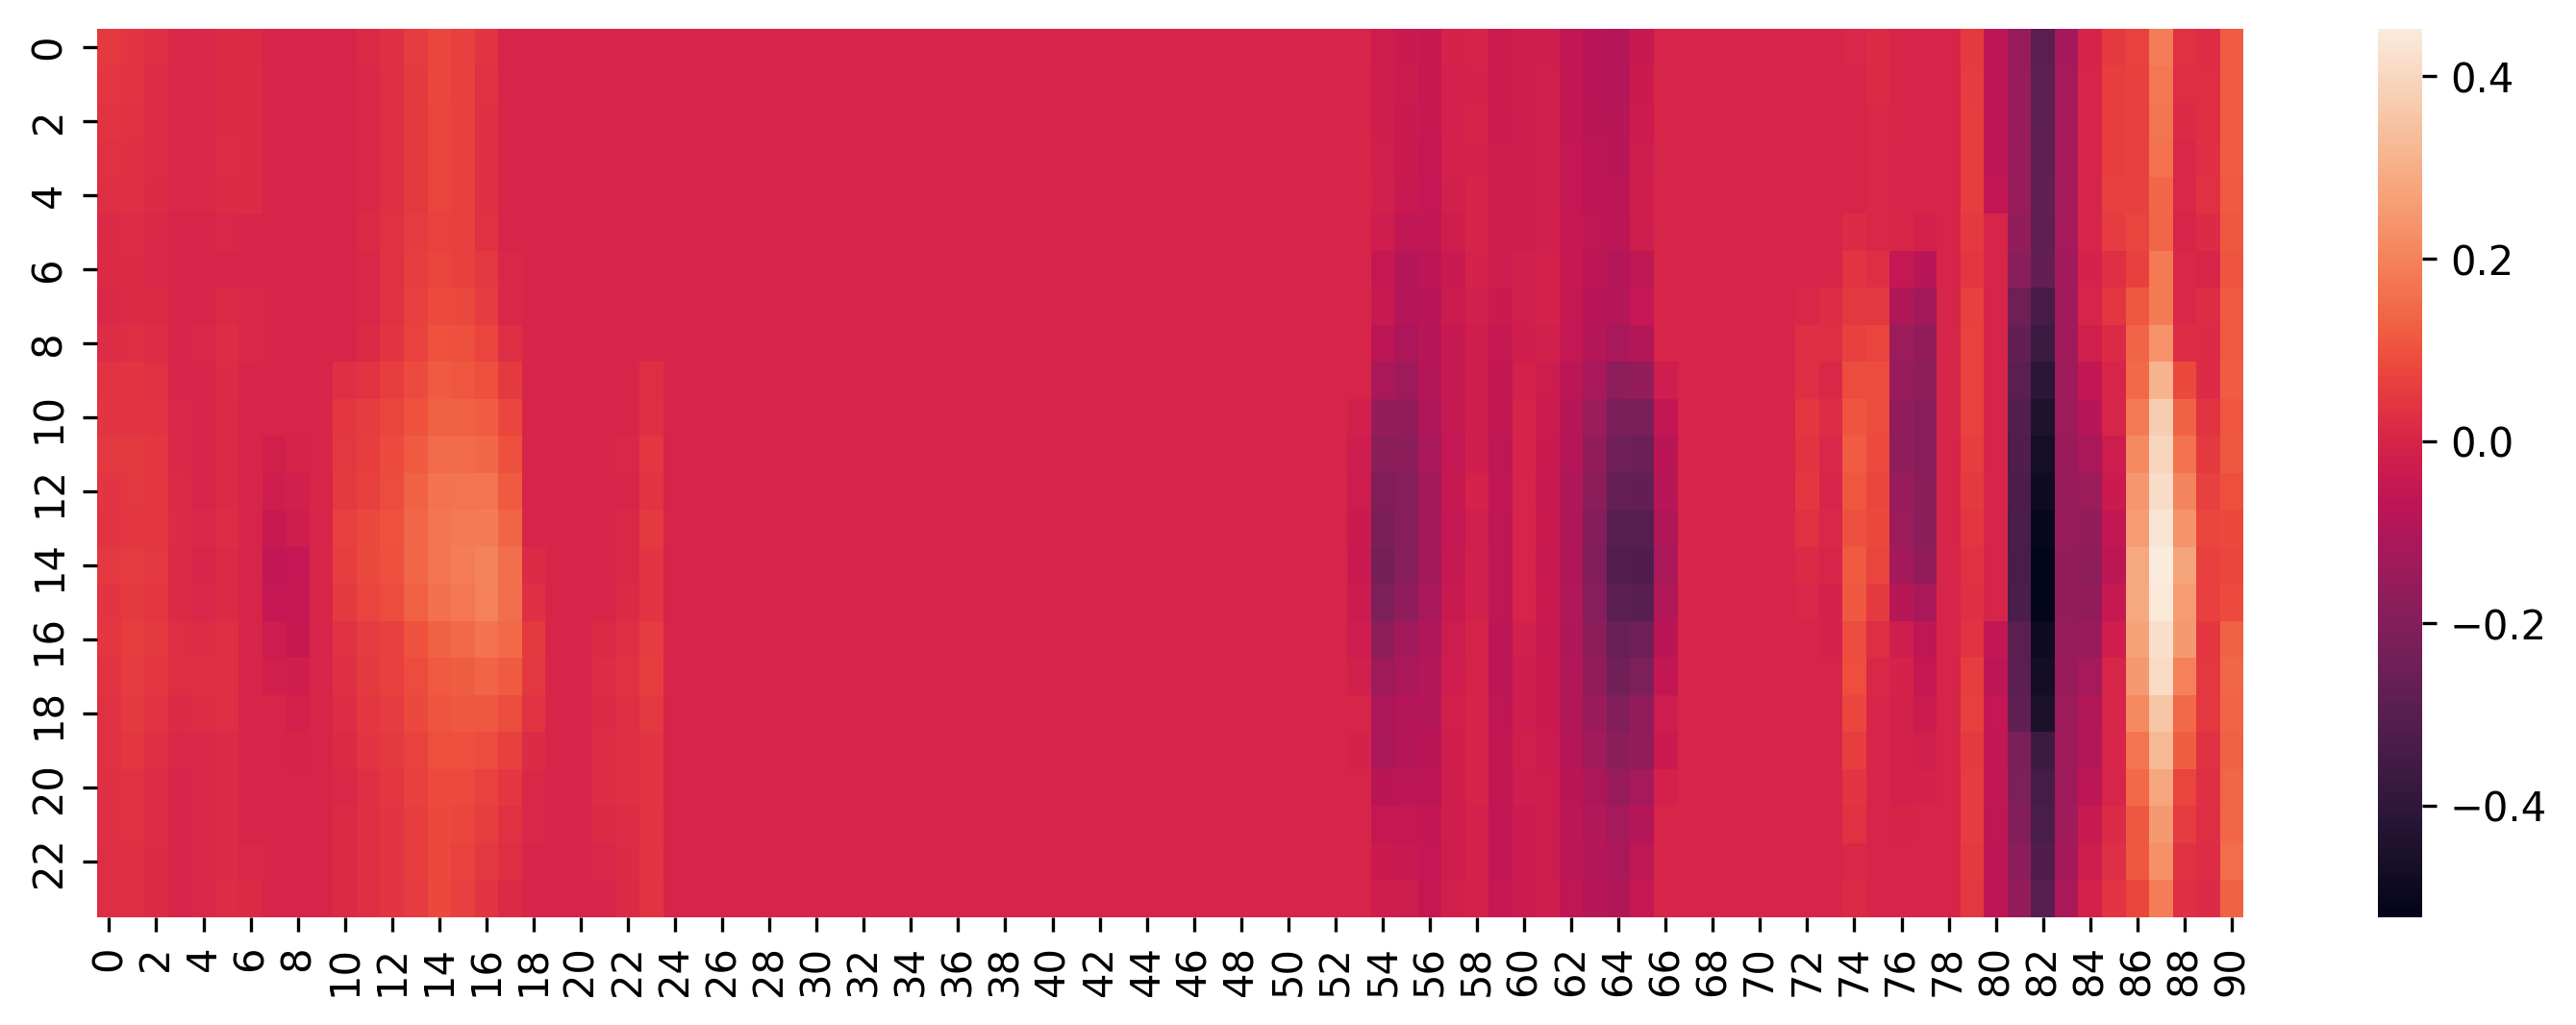

In [32]:
# heatmap fro the model._model.coef_
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model_coef = model._model.coef_
# # assuming model_coef is a 1D array, we reshape it to 2D for the heatmap
# model_coef_2d = model_coef.reshape(-1, 1)

#fig size
plt.rcParams['figure.figsize'] = [12, 4]
sns.heatmap(model_coef)
plt.show()
# get the model coefficients

In [33]:
pred_baseline

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted
datetime,,,,,,,,
2019-03-02 00:00:00,52.76180,104.800000,96.111425,0.0,0.0,0.0,False,142.817930
2019-03-02 01:00:00,51.43775,104.800000,98.272022,0.0,0.0,0.0,False,142.483776
2019-03-02 02:00:00,51.08000,104.800000,98.175642,0.0,0.0,0.0,False,142.433260
2019-03-02 03:00:00,51.08000,104.800000,96.926643,0.0,0.0,0.0,False,141.970944
2019-03-02 04:00:00,51.07078,104.800000,94.924831,0.0,0.0,0.0,False,141.350226
...,...,...,...,...,...,...,...,...
2020-02-29 19:00:00,53.06000,153.600000,140.780725,0.0,0.0,NaN,True,NaN
2020-02-29 20:00:00,53.04845,148.800000,136.584485,0.0,0.0,NaN,True,NaN
2020-02-29 21:00:00,51.86075,140.000000,134.143621,0.0,0.0,NaN,True,NaN


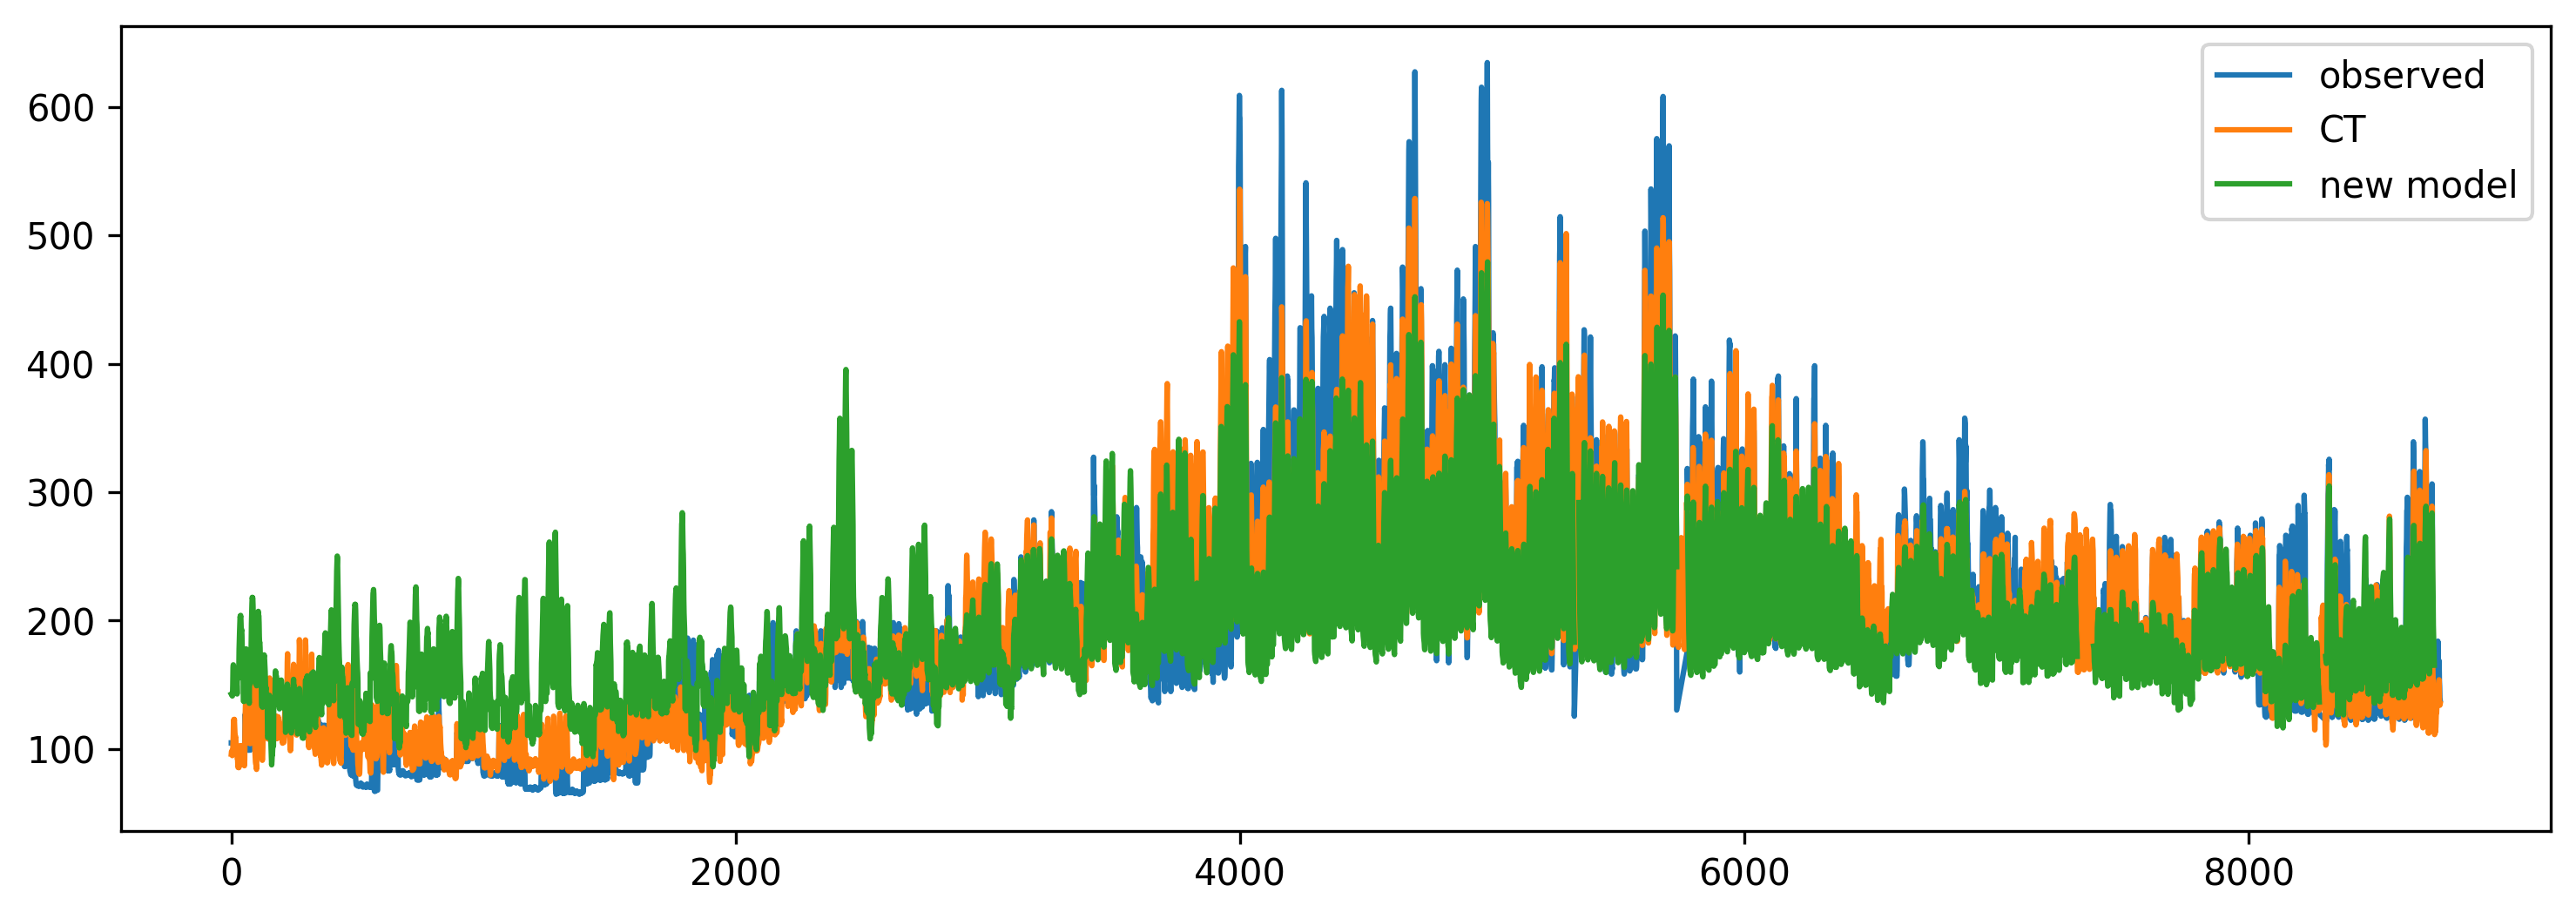

In [34]:
s = 0
w = -1
e = s + w
plt.plot(pred_baseline['observed'].iloc[s:e].values, label='observed')
plt.plot(pred_baseline['model'].iloc[s:e].values, label='CT')
plt.plot(pred_baseline['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [35]:
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()
data_reporting = HourlyData(meter_reporting, **kwargs)
reporting_pred = model.predict(data_reporting)
reporting_pred

ValueError: Input X contains NaN.
ElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

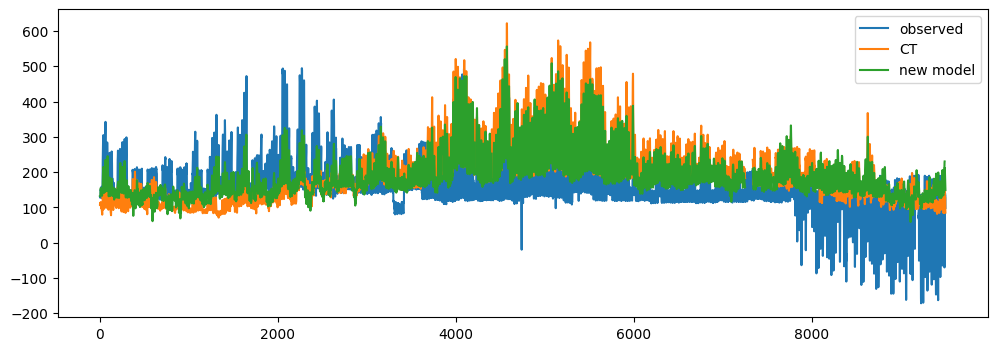

In [ ]:
s = 0
w = -1
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [ ]:
# pred['temperature'].quantile(0.95)
# find days with temperature above 95th percentile
hot_hours = reporting_pred[reporting_pred['temperature'] > reporting_pred['temperature'].quantile(0.995)]
unique_days = np.unique(hot_hours.index.date)
print(unique_days.shape)

reporting_pred['date'] = reporting_pred.index.date
 # get days that are in unique_days
hot_days = reporting_pred[reporting_pred['date'].isin(unique_days)]
hot_days

(12,)


,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted,date
datetime,,,,,,,,,
2020-05-26 00:00:00,71.54255,168.000000,133.048856,1.0,0.0,0.0,False,177.086395,2020-05-26
2020-05-26 01:00:00,68.77550,156.800000,132.049642,1.0,0.0,0.0,False,174.072296,2020-05-26
2020-05-26 02:00:00,66.79550,160.800000,130.941328,1.0,0.0,0.0,False,172.300649,2020-05-26
2020-05-26 03:00:00,64.82075,168.000000,129.424340,1.0,0.0,0.0,False,170.332085,2020-05-26
2020-05-26 04:00:00,63.38405,161.600000,125.151462,1.0,0.0,0.0,False,168.757252,2020-05-26
...,...,...,...,...,...,...,...,...,...
2020-09-07 19:00:00,98.17325,258.399999,427.049020,1.0,0.0,0.0,False,365.373075,2020-09-07
2020-09-07 20:00:00,94.57100,167.200000,383.211490,1.0,0.0,0.0,False,330.567824,2020-09-07
2020-09-07 21:00:00,90.60995,195.200000,334.064123,1.0,0.0,0.0,False,310.585681,2020-09-07


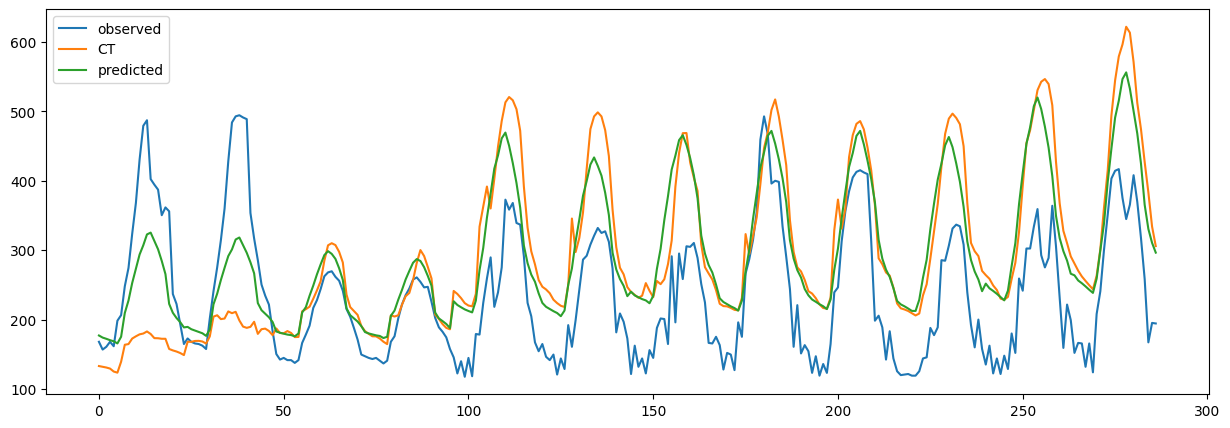

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
s = 24*0
w = -1
e = s + w
plt.plot(hot_days['observed'].iloc[s:e].values, label='observed')
plt.plot(hot_days['model'].iloc[s:e].values, label='CT')
plt.plot(hot_days['predicted'].iloc[s:e].values, label='predicted')
plt.legend()

# plt.plot(-hot_days['ghi'].iloc[s:e].values*7, label='ghi')

plt.show()

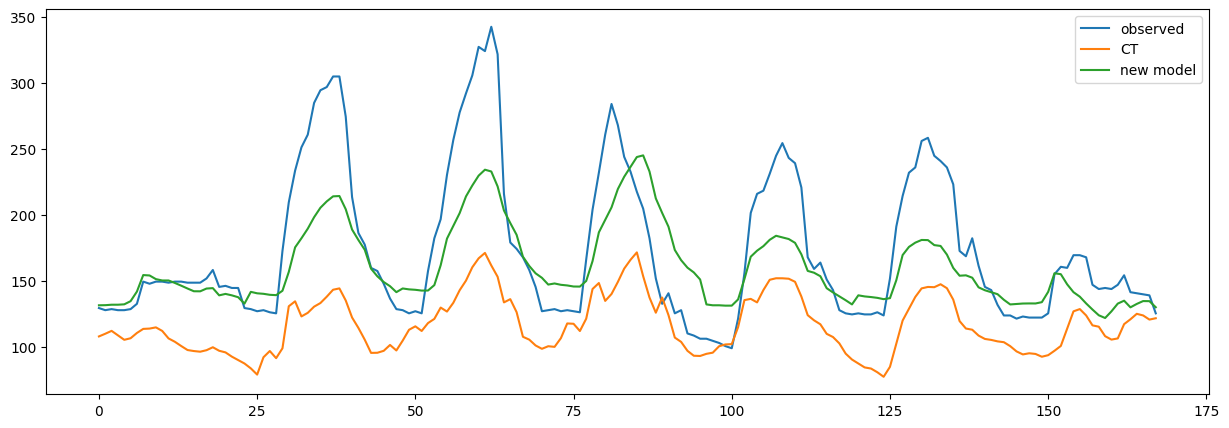

In [ ]:
s = 24*0
w = 24*7
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [ ]:
def PNRMSE(y_true, y_pred, iqr):
    return np.sqrt(np.mean((y_true - y_pred)**2))/iqr

def CVRMSE(y_true, y_pred, mn):
    return np.sqrt(np.mean((y_true - y_pred)**2))/mn

def MBE(y_true, y_pred):
    return np.mean(y_true - y_pred)



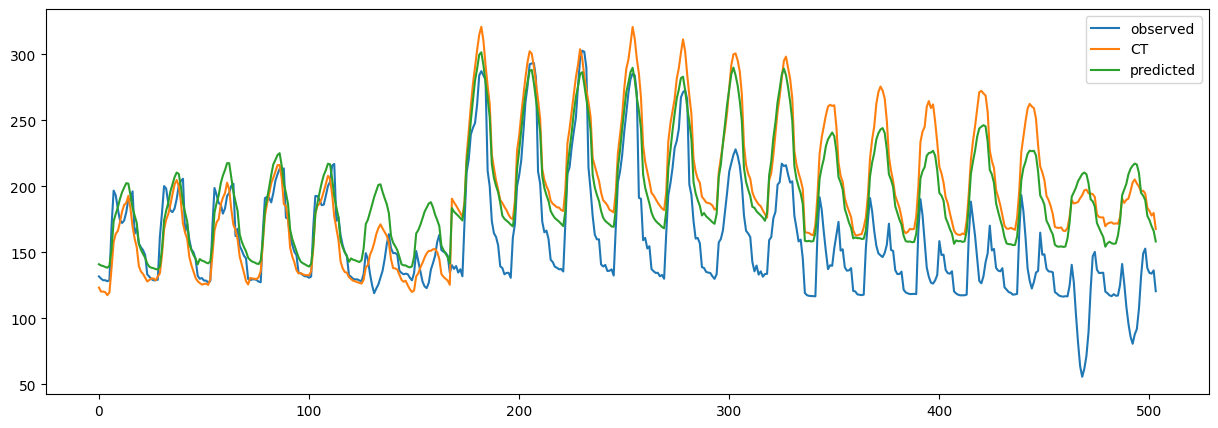

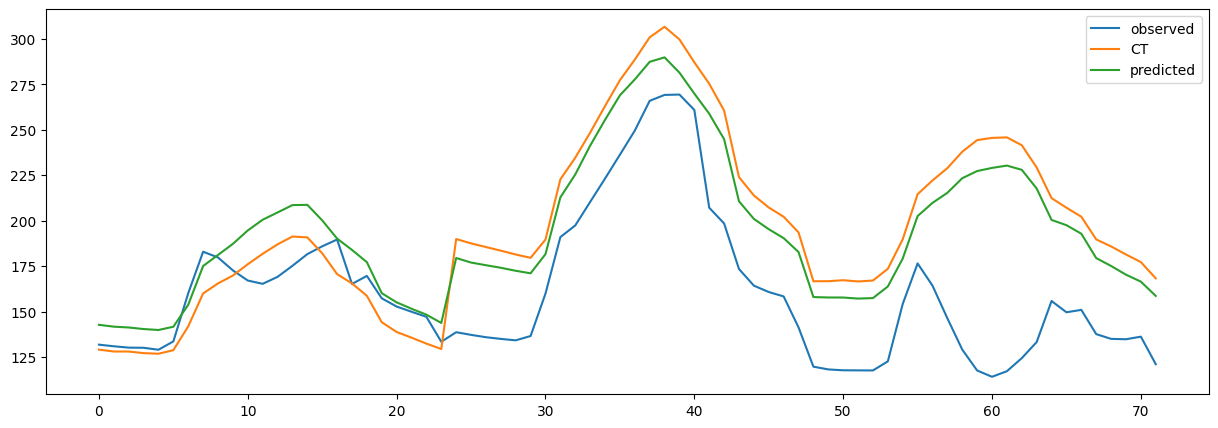

In [ ]:
# plot the season/hour_of_week plots
# get the season and hour_of_week
seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
reporting_pred['season'] = reporting_pred.index.month
reporting_pred['season'] = reporting_pred['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
reporting_pred['season'] = reporting_pred['season'].astype('category')

reporting_pred['hour_of_week'] = reporting_pred.index.dayofweek*24 + reporting_pred.index.hour
reporting_pred['hour_of_week'] = reporting_pred['hour_of_week'].astype('category')

reporting_pred['hour'] = reporting_pred.index.hour
reporting_pred['hour'] = reporting_pred['hour'].astype('category')


# get the season/hour_of_week plots
plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()


plt.plot(reporting_pred.groupby(['season', 'hour'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()

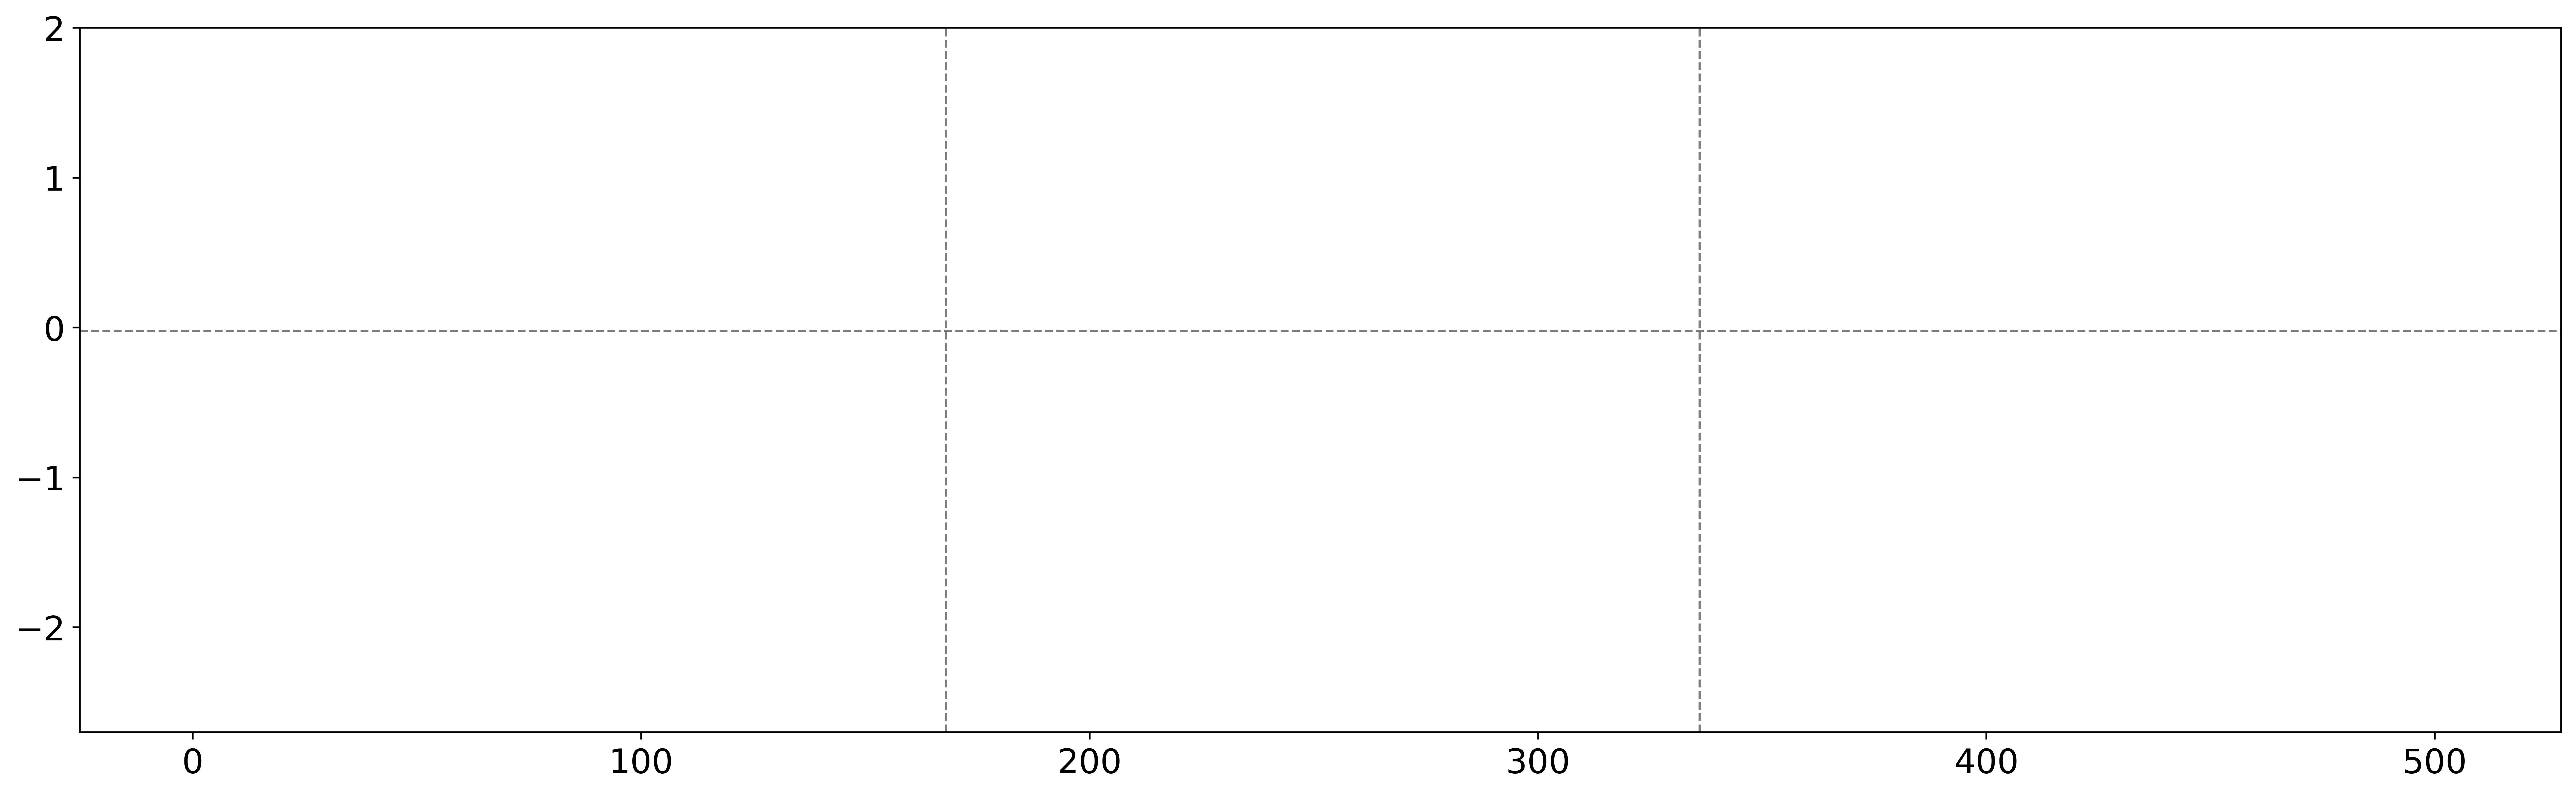

{'PNRMSE': 0.9196297696170674,
 'PNRMSE_predicted': 0.775574345913523,
 'CVRMSE': 0.45467716695698257,
 'CVRMSE_predicted': 0.3834542530210963,
 'MBE': -32.19466583964722,
 'MBE_predicted': -31.070126718545506}

In [ ]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()

seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
dft['season'] = dft.index.month
dft['season'] = dft['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
dft['season'] = dft['season'].astype('category')

dft['hour_of_week'] = dft.index.dayofweek*24 + dft.index.hour
dft['hour_of_week'] = dft['hour_of_week'].astype('category')

dft['hour'] = dft.index.hour
dft['hour'] = dft['hour'].astype('category')

# plot two weeks of data for oeem , new_model and observed
start = 24*0
pltwindow = 24*7
end = start + pltwindow

plt.rcParams["figure.figsize"] = (21,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 500
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
# plt.plot(dft['observed'][start:end].values, label='observed', linewidth=2.5)

plt.plot(dft.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed', linewidth=2.5)
# plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT',color='red',  linewidth=2.5)
plt.plot(dft.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted', color='red', linewidth=4.5)

# plt.plot(-dft['ghi'][start:end].values*10, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'][start:end].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['new_model'][start:end].values, label='new_model', color='mediumseagreen',linestyle='--', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
plt.axvline(168, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.xticks(fontsize=16)
#change s tick to time
# plt.xticks(dft['start_local'].index[start:end].values, dft['start_local'].index[start:end].values, rotation=45)
plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(-0.02, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
plt.ylim(-2.7, 2)
# plt.legend()
plt.show()


iqr = np.percentile(pred_baseline['observed'], 75) - np.percentile(pred_baseline['observed'], 25)
mn = np.mean(pred_baseline['observed'])

# get metrics both for model and predicted based on observed
metrics = {}
metrics['PNRMSE'] = PNRMSE(dft['observed'], dft['model'], iqr)
metrics['PNRMSE_predicted'] = PNRMSE(dft['observed'], dft['predicted'], iqr)
metrics['CVRMSE'] = CVRMSE(dft['observed'], dft['model'], mn)
metrics['CVRMSE_predicted'] = CVRMSE(dft['observed'], dft['predicted'], mn)
metrics['MBE'] = MBE(dft['observed'], dft['model'])
metrics['MBE_predicted'] = MBE(dft['observed'], dft['predicted'])

metrics

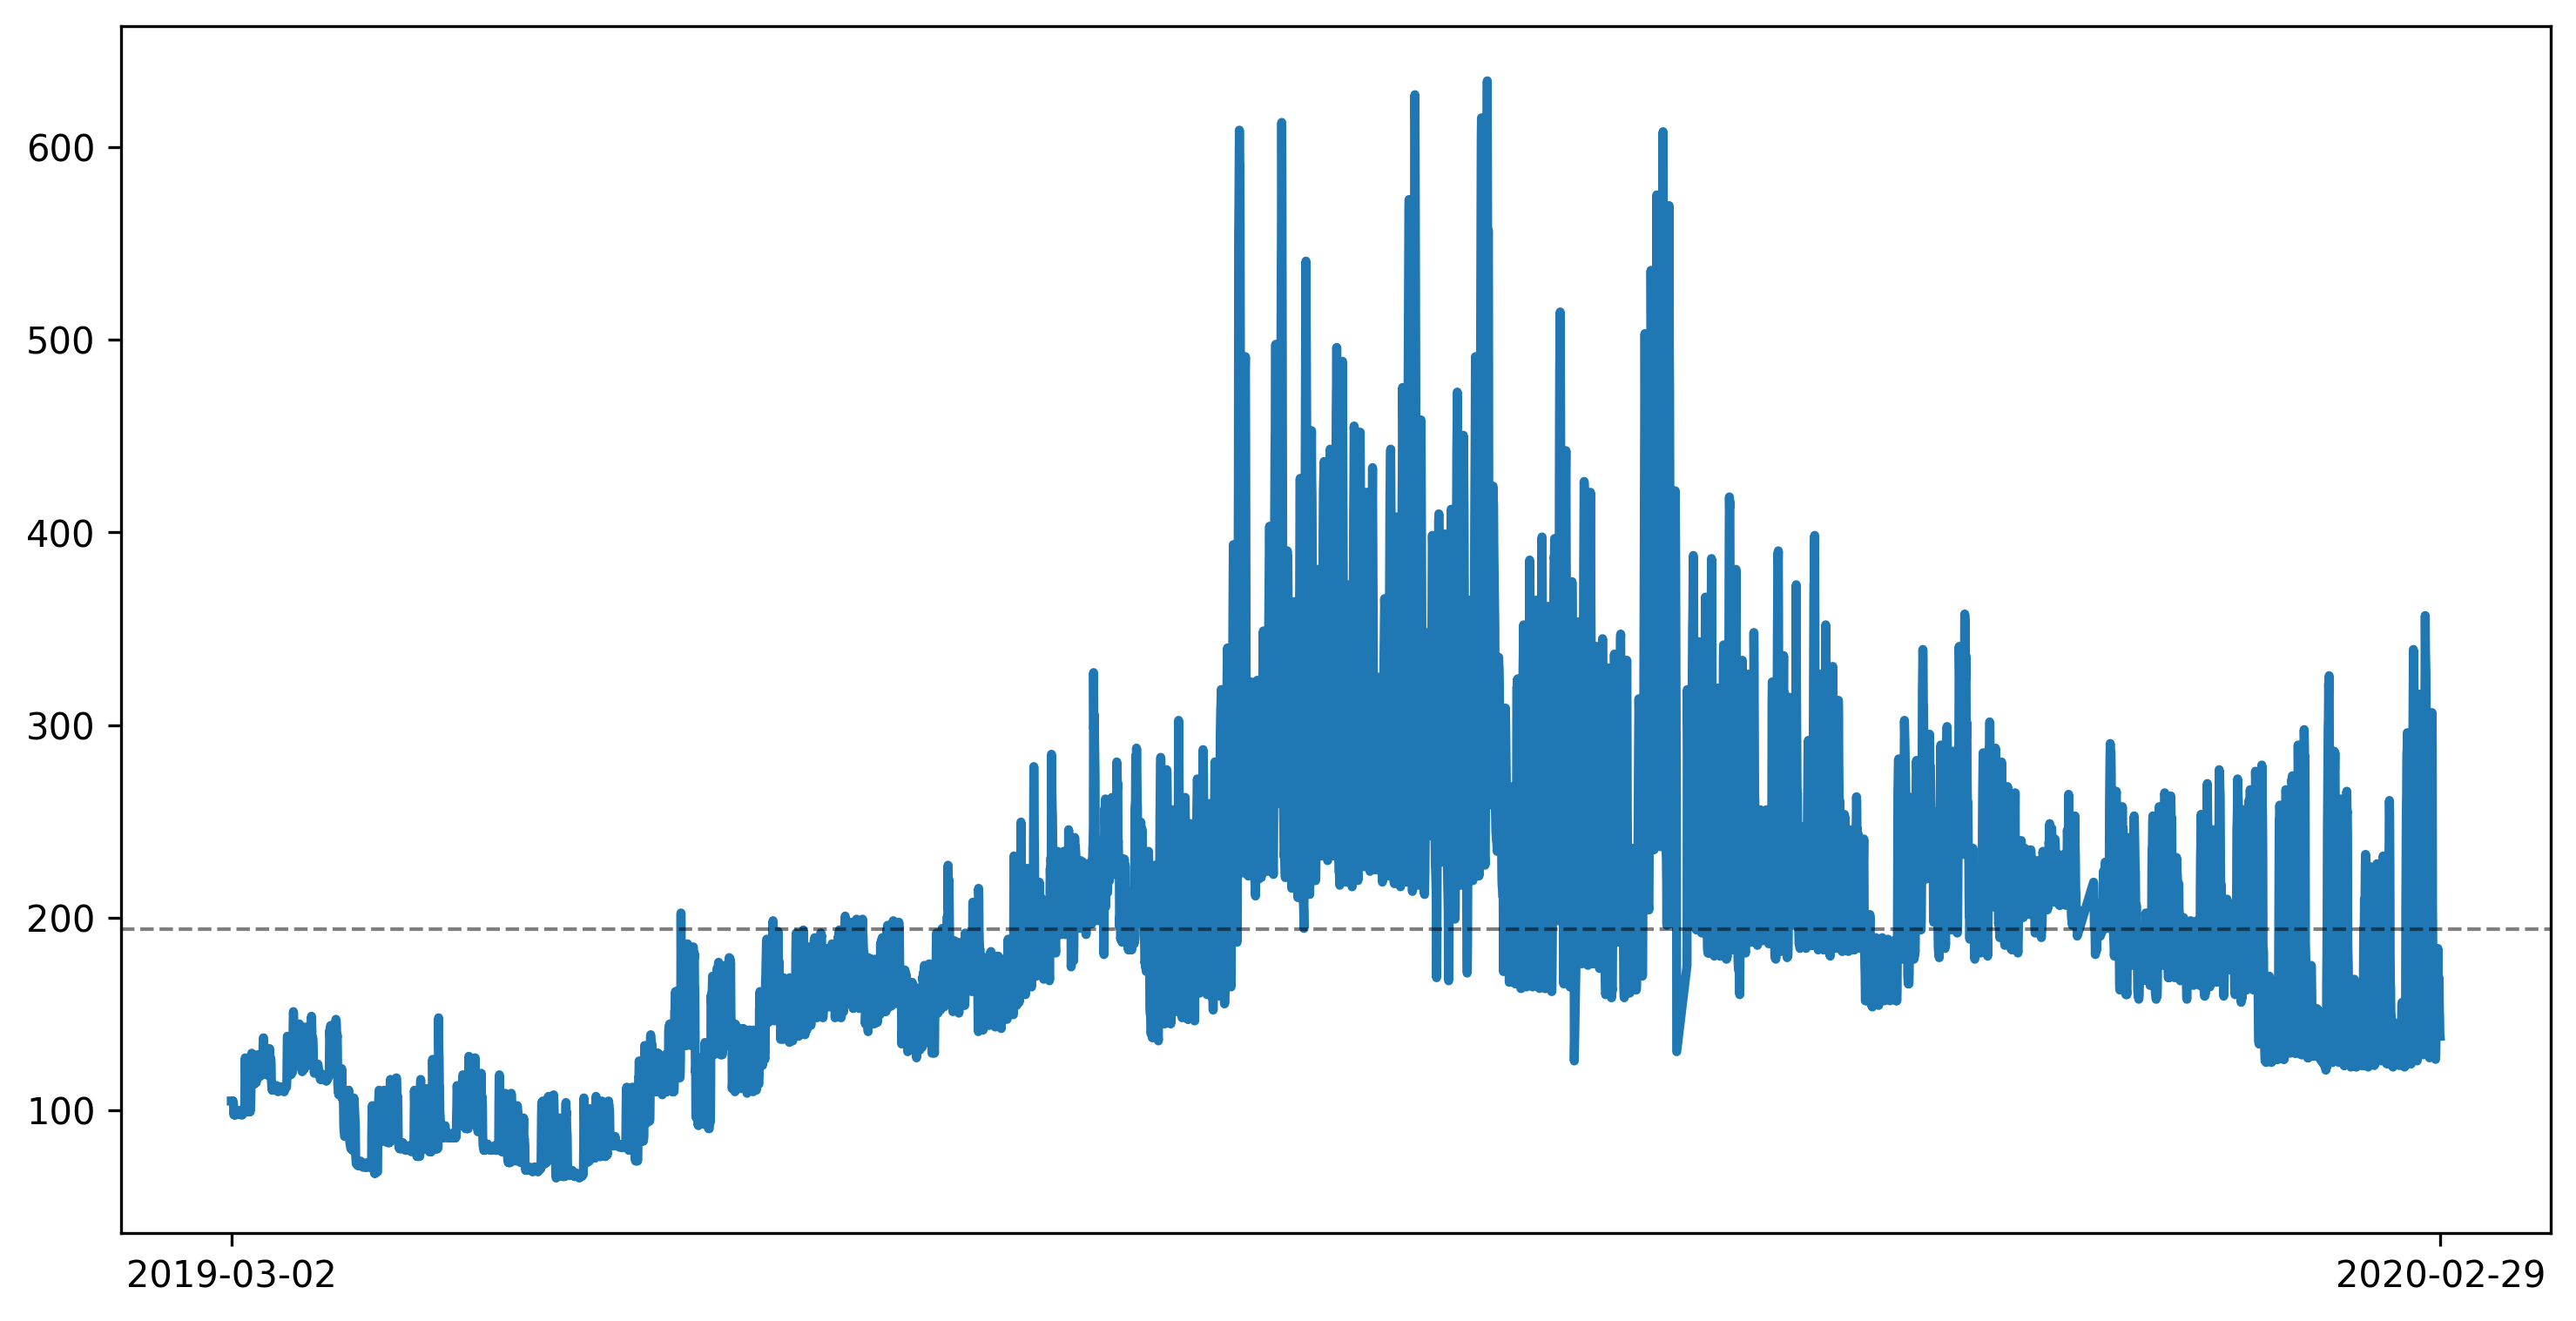

In [ ]:
# dft = reporting_pred.copy()
dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
# plt.xticks([0, 11, 23, 35, 47], [1, 12, 24, 36, 48])

# add the first and the last date to the xticks
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])

# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
# dft = pred_baseline.copy()
# dft['observed'].describe()
# idx = dft['observed'].argmin() -24*2
# print(idx)

# selected_date = dft.index[idx].date()
# # get the data for the selected date
# selected_data = dft[dft.index.date == selected_date]


1240


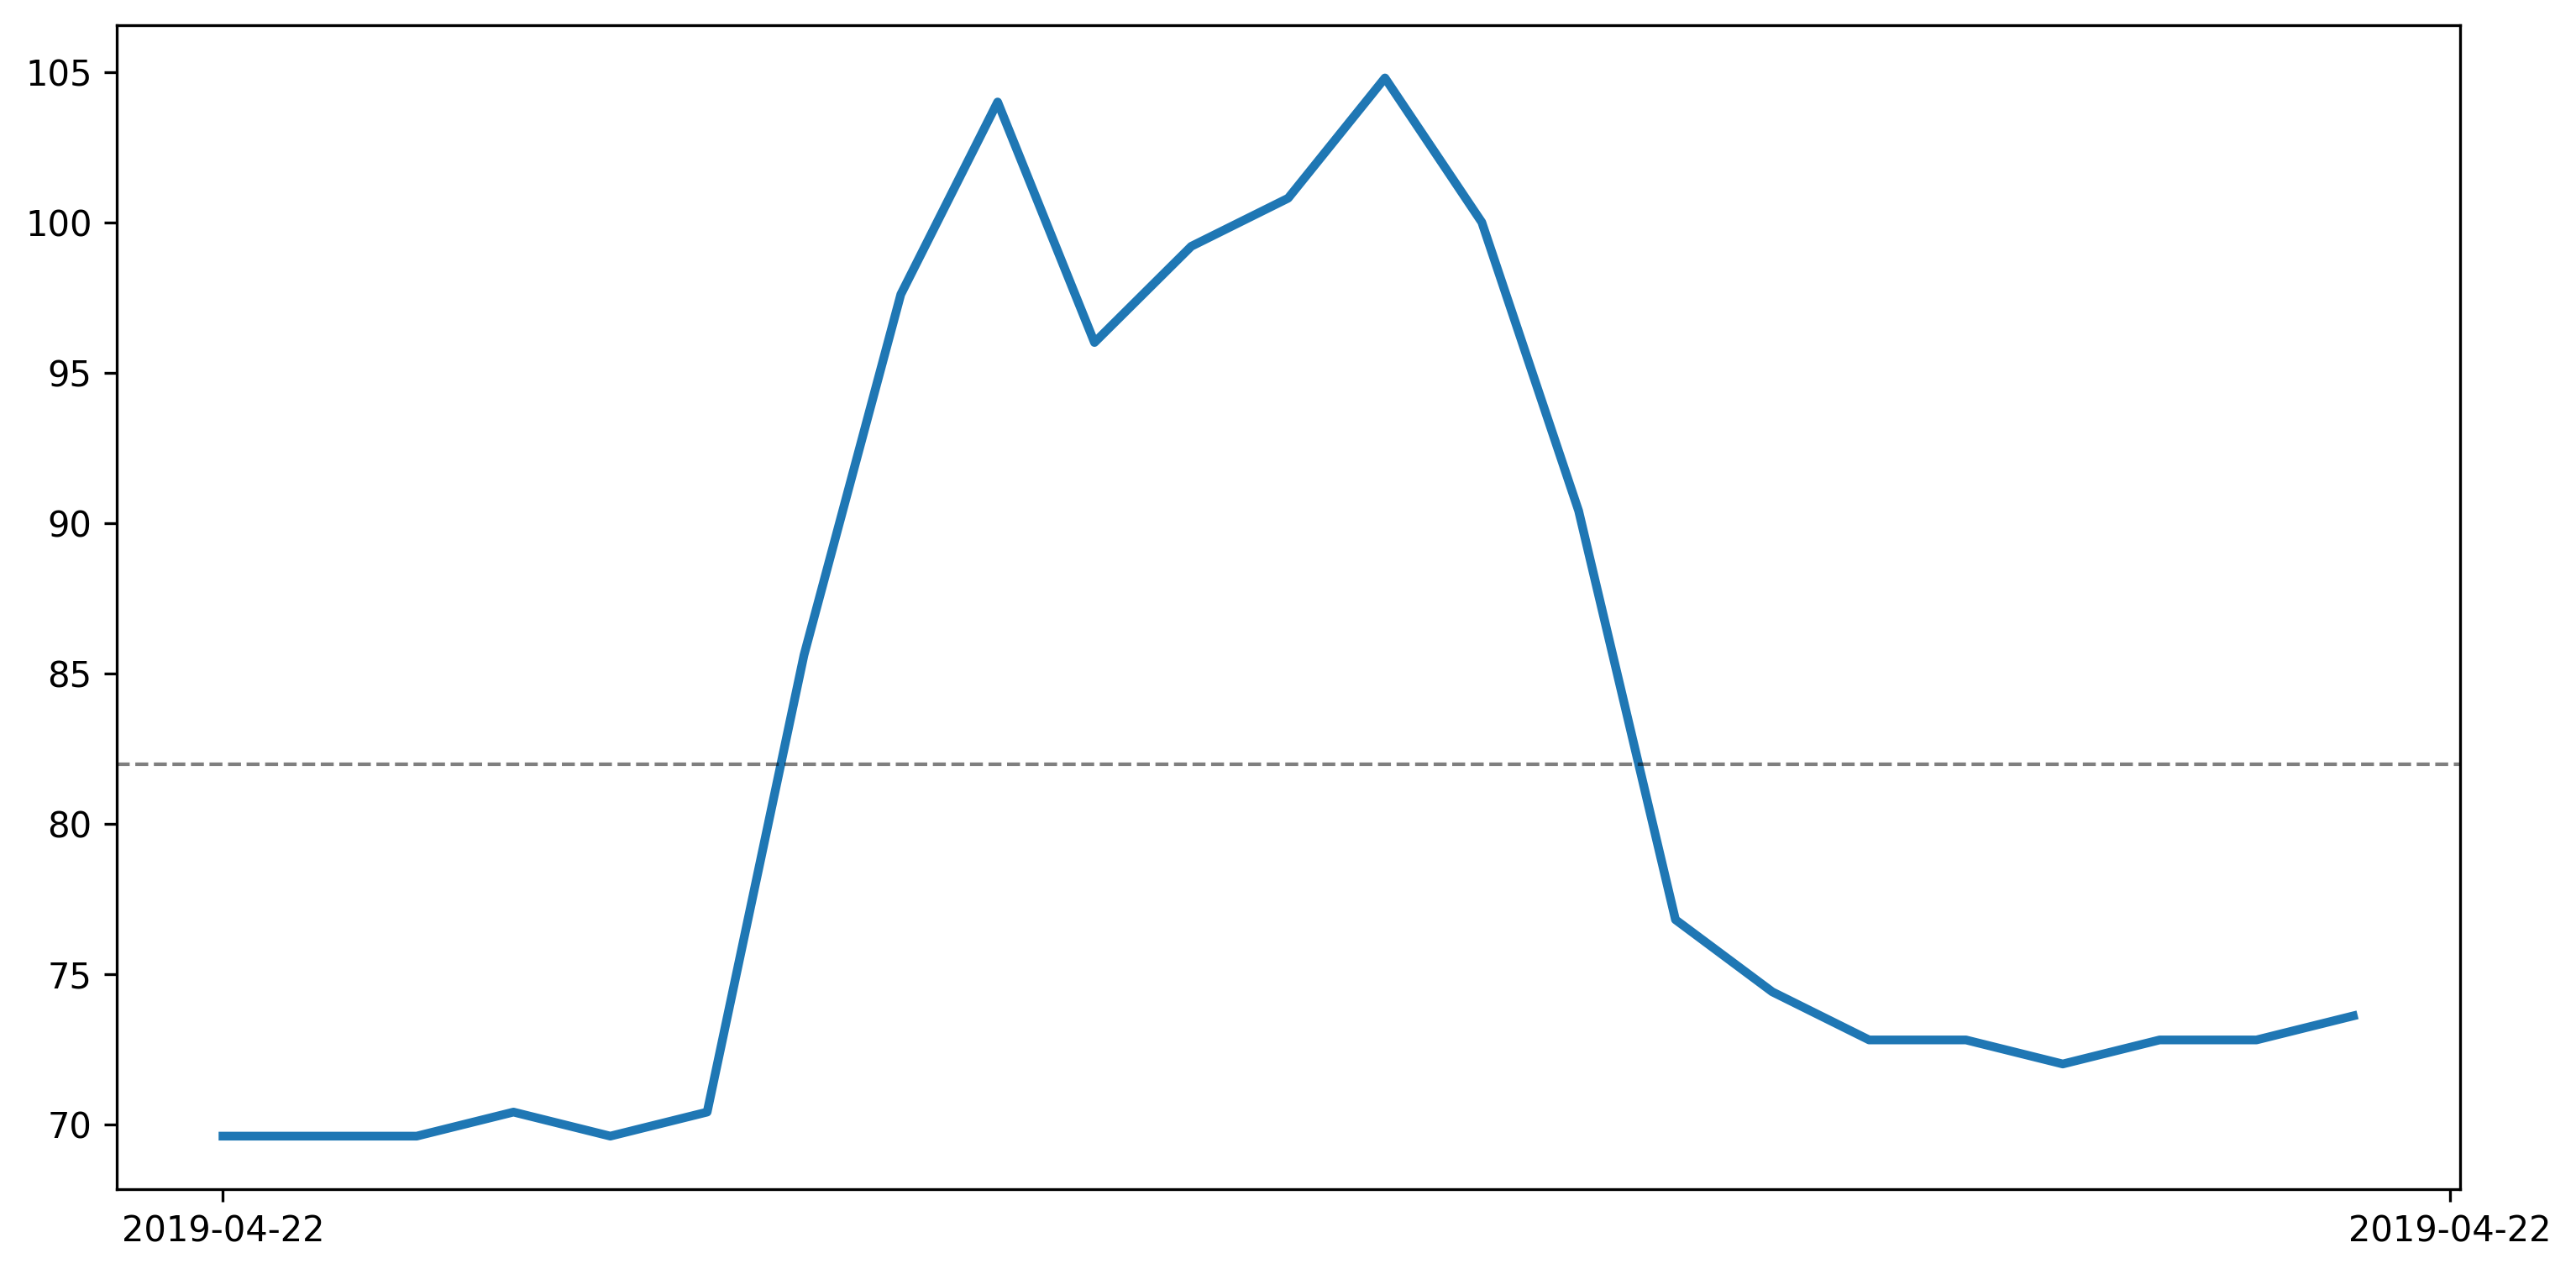

In [ ]:
start = 24*0
pltwindow = -1
end = start + pltwindow
dft = selected_data.copy()
dft = repo
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)

#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

plt.show()

In [ ]:
634.4/208

3.05

In [ ]:
meta_meter

,dpsm_model_id,cohort,s_cust_cl_cd,s_naics_group,has_net,latitude,longitude,zip_code,station_usaf_id,station_latitude,station_longitude,station_ca_climate_zone,days_kept,hours_kept
dpsm_id,,,,,,,,,,,,,,
None-9097391784_1-9097391784_1,None-9097391784_1-9097391784_1__covid,covid,COM/IND,Offices,True,37.991502,-122.286607,94564,724950,37.992,-122.055,CA_12,363,8593
None-9097391784_1-9097391784_1,None-9097391784_1-9097391784_1__pre_covid,pre_covid,COM/IND,Offices,True,37.991502,-122.286607,94564,724950,37.992,-122.055,CA_12,365,8614
None-9097391784_1-9097391784_1,None-9097391784_1-9097391784_1__pre_pre_covid,pre_pre_covid,COM/IND,Offices,True,37.991502,-122.286607,94564,724950,37.992,-122.055,CA_12,29,696


In [ ]:
reporting_pred

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,interpolated,predicted,date,season,hour_of_week,hour
datetime,,,,,,,,,,,,
2020-03-01 00:00:00,49.34405,129.599998,108.136049,1.0,0.0,0.0,False,131.694647,2020-03-01,shoulder,144,0
2020-03-01 01:00:00,48.37145,128.000000,110.160731,1.0,0.0,0.0,False,131.777758,2020-03-01,shoulder,145,1
2020-03-01 02:00:00,47.37560,128.799999,112.343598,1.0,0.0,0.0,False,132.124153,2020-03-01,shoulder,146,2
2020-03-01 03:00:00,47.59070,128.000000,108.934107,1.0,0.0,0.0,False,132.133611,2020-03-01,shoulder,147,3
2020-03-01 04:00:00,48.01370,127.999999,105.573819,1.0,0.0,0.0,False,132.414299,2020-03-01,shoulder,148,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 20:00:00,69.97400,135.199999,111.509808,1.0,0.0,0.0,False,161.494974,2021-03-31,shoulder,68,20
2021-03-31 21:00:00,64.95185,134.399999,92.703606,1.0,0.0,0.0,False,156.913067,2021-03-31,shoulder,69,21
2021-03-31 22:00:00,61.75550,133.599998,89.702138,1.0,0.0,0.0,False,153.232612,2021-03-31,shoulder,70,22


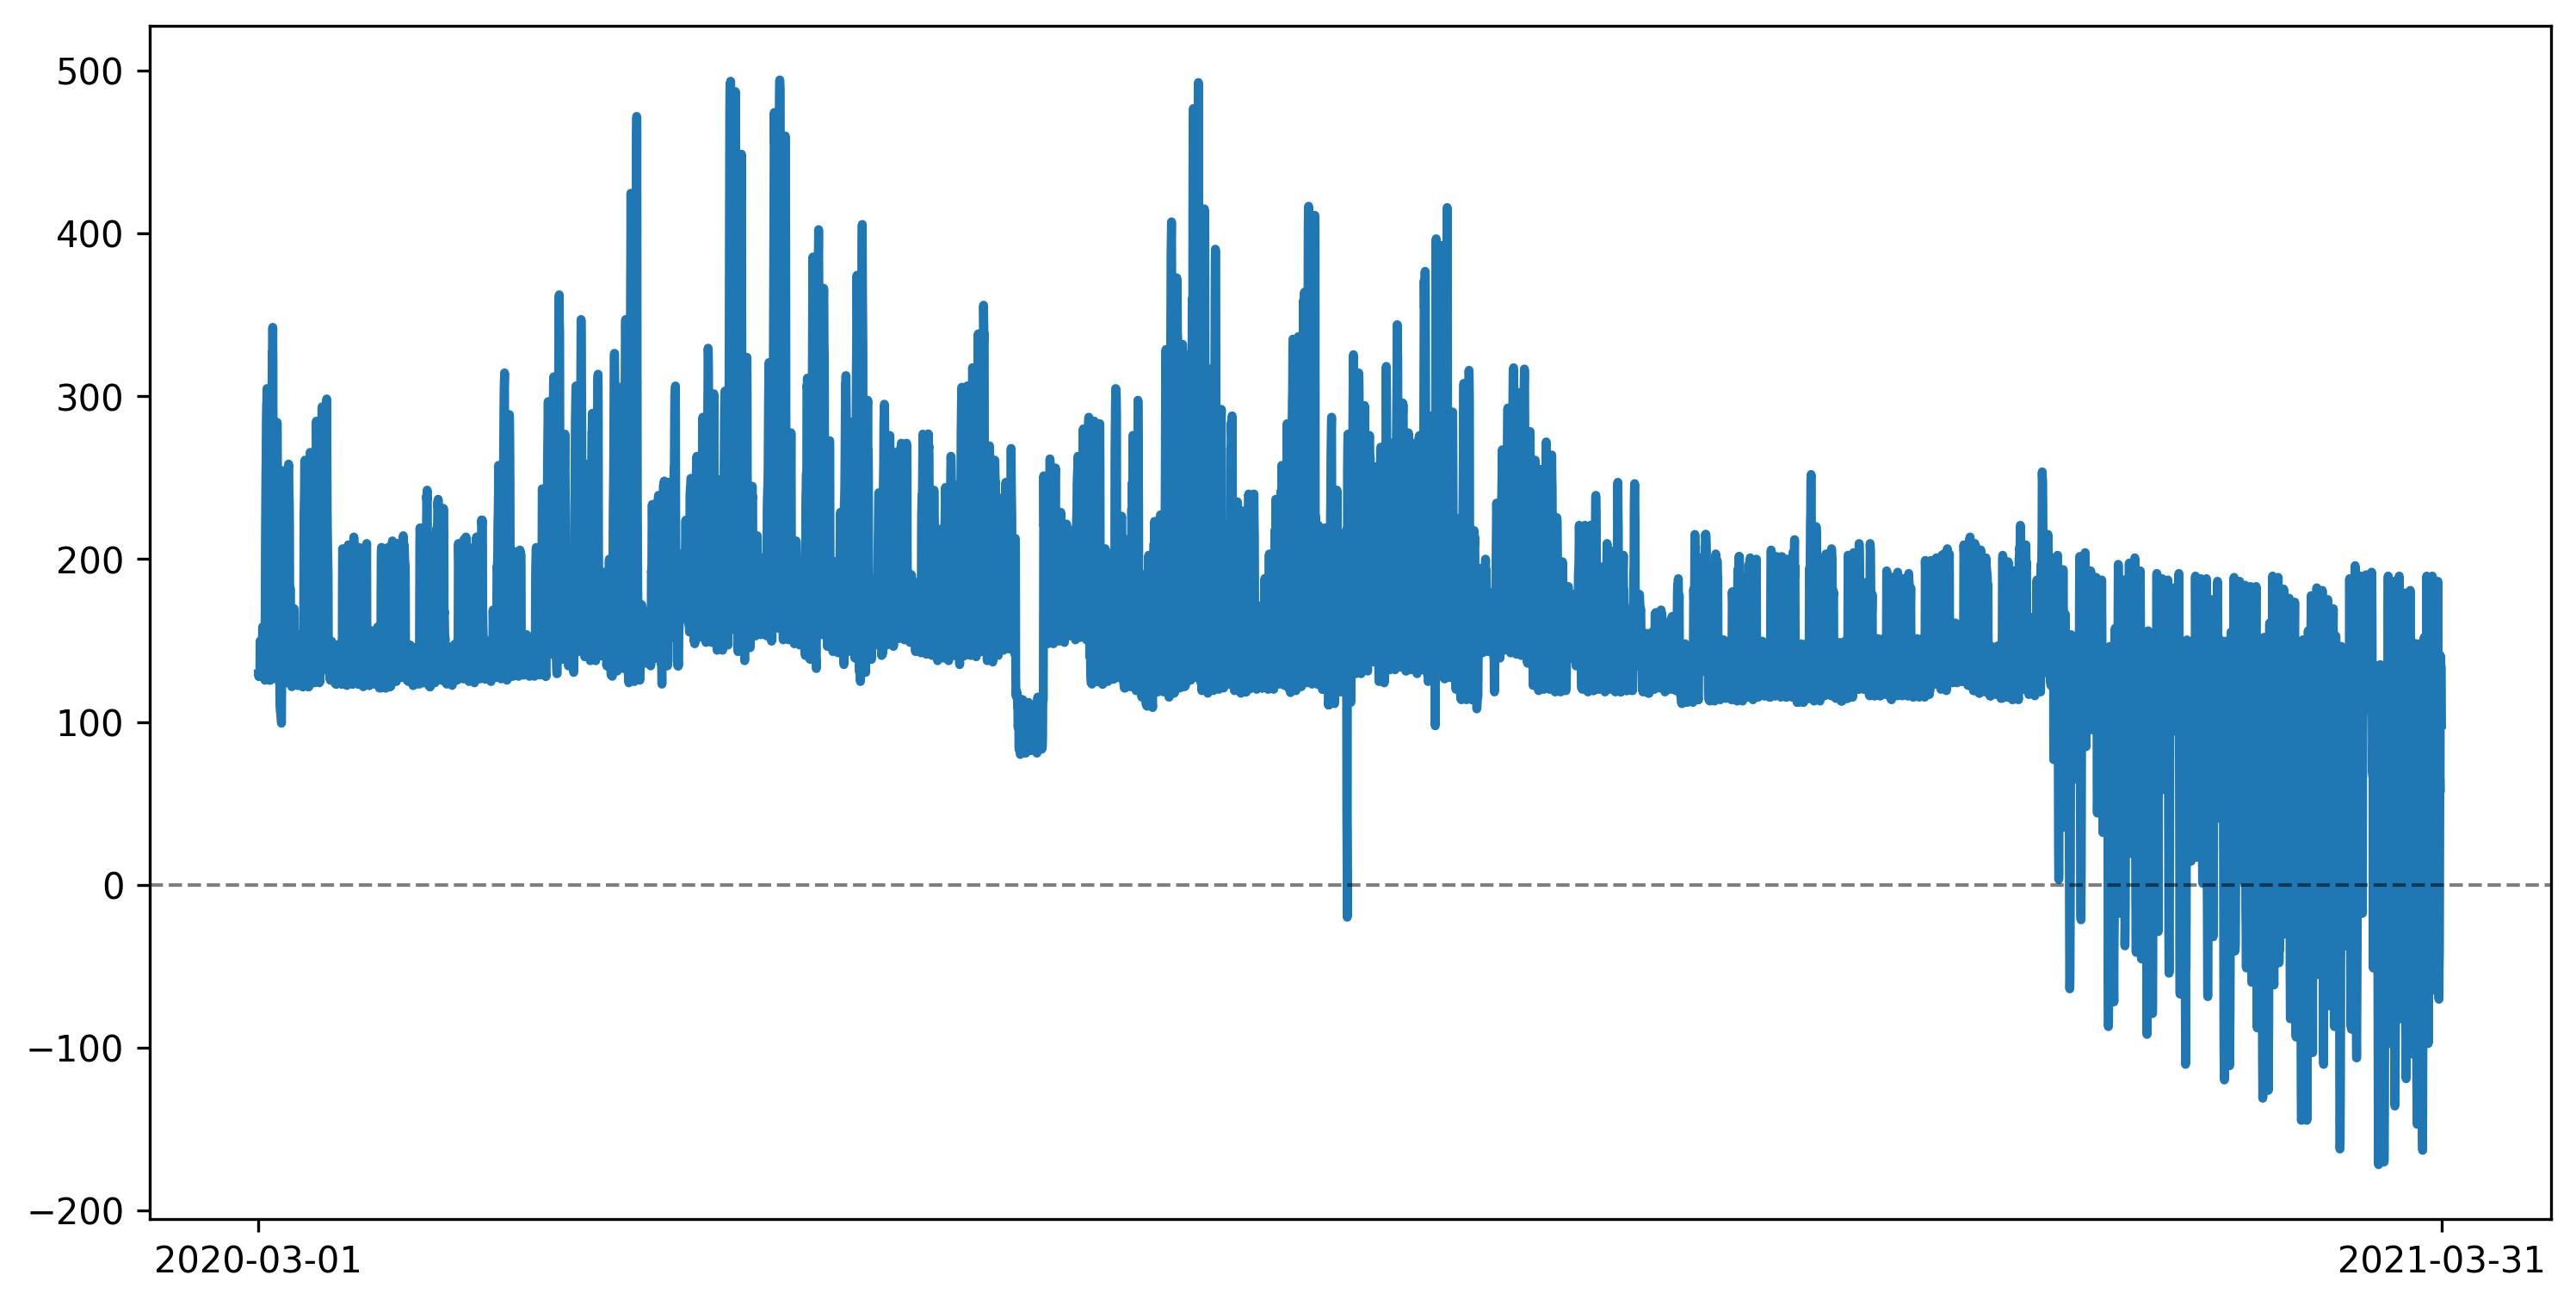

In [37]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(0, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
reporting_pred.describe()

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,predicted
count,9504.000000,9504.000000,9418.000000,9504.0,9504.000000,9504.000000,9336.000000
mean,61.877841,160.453998,192.638539,1.0,0.222600,0.245365,191.664685
std,13.469464,69.397191,79.977040,0.0,0.303603,0.319010,65.059412
min,33.980000,-172.000000,70.817906,1.0,0.000000,0.000000,58.473541
25%,51.974750,127.200000,133.360687,1.0,0.000000,0.000000,148.813382
50%,60.084345,149.600000,182.661975,1.0,0.007000,0.010000,176.828170
75%,69.844962,191.200000,226.505825,1.0,0.435250,0.493000,217.544865
max,111.533900,494.400000,621.856708,1.0,1.049000,1.049000,556.154166


In [38]:
# select reporting period after the intervention
selected = reporting_pred.loc[reporting_pred.index >= PV_interventation]
selected.describe()

,temperature,observed,model,solar_supp,ghi,clearsky_ghi,predicted
count,1680.000000,1680.000000,1680.000000,1680.0,1680.000000,1680.000000,1677.000000
mean,53.211148,90.252857,151.170839,1.0,0.175900,0.207873,159.554708
std,8.276649,76.746706,40.070890,0.0,0.257193,0.280812,34.951624
min,33.980000,-172.000000,81.466911,1.0,0.000000,0.000000,58.473541
25%,47.364050,65.400000,122.517735,1.0,0.000000,0.000000,134.157505
50%,51.867050,118.400000,144.728159,1.0,0.000000,0.000000,155.221653
75%,58.226300,135.999999,170.326826,1.0,0.317000,0.453000,182.556215
max,82.033700,204.000000,367.356870,1.0,0.923000,0.923000,300.408907
